## Project 3

# Darshan Pai - Model Training using ANN and 1D-CNN on INCART DB

References for the Project
Watch a 12 lead ECG video https://www.youtube.com/watch?v=kwLbSx9BNbU

DataSet location: https://physionet.org/content/incartdb/1.0.0/

## Import all the necessary libraries

In [2]:
import wfdb
from wfdb import processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import peakutils
import csv

## Download the INCART Data from Physionet

In [2]:
# Download all the WFDB records and annotations from a small Physionet Database

# Make a temporary download directory in your current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'tmp_dl_dir')

In [2]:
# Download all the WFDB content
wfdb.dl_database('incartdb', dl_dir=dl_dir)

# Display the downloaded content in the folder
display(os.listdir(dl_dir))

# Cleanup: delete the downloaded directory
#shutil.rmtree(dl_dir)

Generating record list for: I01
Generating record list for: I02
Generating record list for: I03
Generating record list for: I04
Generating record list for: I05
Generating record list for: I06
Generating record list for: I07
Generating record list for: I08
Generating record list for: I09
Generating record list for: I10
Generating record list for: I11
Generating record list for: I12
Generating record list for: I13
Generating record list for: I14
Generating record list for: I15
Generating record list for: I16
Generating record list for: I17
Generating record list for: I18
Generating record list for: I19
Generating record list for: I20
Generating record list for: I21
Generating record list for: I22
Generating record list for: I23
Generating record list for: I24
Generating record list for: I25
Generating record list for: I26
Generating record list for: I27
Generating record list for: I28
Generating record list for: I29
Generating record list for: I30
Generating record list for: I31
Generati

['I01.atr',
 'I01.dat',
 'I01.hea',
 'I02.atr',
 'I02.dat',
 'I02.hea',
 'I03.atr',
 'I03.dat',
 'I03.hea',
 'I04.atr',
 'I04.dat',
 'I04.hea',
 'I05.atr',
 'I05.dat',
 'I05.hea',
 'I06.atr',
 'I06.dat',
 'I06.hea',
 'I07.atr',
 'I07.dat',
 'I07.hea',
 'I08.atr',
 'I08.dat',
 'I08.hea',
 'I09.atr',
 'I09.dat',
 'I09.hea',
 'I10.atr',
 'I10.dat',
 'I10.hea',
 'I11.atr',
 'I11.dat',
 'I11.hea',
 'I12.atr',
 'I12.dat',
 'I12.hea',
 'I13.atr',
 'I13.dat',
 'I13.hea',
 'I14.atr',
 'I14.dat',
 'I14.hea',
 'I15.atr',
 'I15.dat',
 'I15.hea',
 'I16.atr',
 'I16.dat',
 'I16.hea',
 'I17.atr',
 'I17.dat',
 'I17.hea',
 'I18.atr',
 'I18.dat',
 'I18.hea',
 'I19.atr',
 'I19.dat',
 'I19.hea',
 'I20.atr',
 'I20.dat',
 'I20.hea',
 'I21.atr',
 'I21.dat',
 'I21.hea',
 'I22.atr',
 'I22.dat',
 'I22.hea',
 'I23.atr',
 'I23.dat',
 'I23.hea',
 'I24.atr',
 'I24.dat',
 'I24.hea',
 'I25.atr',
 'I25.dat',
 'I25.hea',
 'I26.atr',
 'I26.dat',
 'I26.hea',
 'I27.atr',
 'I27.dat',
 'I27.hea',
 'I28.atr',
 'I28.dat',
 'I2

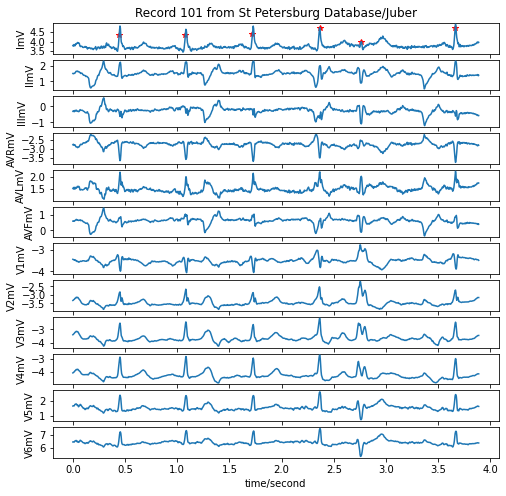

In [3]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(dl_dir+'/I01', sampto = 1000)
annotation = wfdb.rdann(dl_dir+'/I01', 'atr', sampto = 1000)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 101 from St Petersburg Database/Juber',
               time_units='seconds')

In [4]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(10, 5), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


In [5]:
## Process all the data-set using neurokit 
import neurokit2 as nk

In [117]:
def process_data(dl_dir, channel=0, filename="data"):
    patients = {}
    for root, directories, files in os.walk(dl_dir, topdown=False):
        # print(f"{root} {directories} {files}")
        for file in files:
            patients[os.path.splitext(file)[0]] = os.path.join(root,os.path.splitext(file)[0])

    # patients = list(patients)
    # print(patients)
    # print(f"Number {len(patients)}")
    for i in range(1,44):
        del patients['I'+str(i).zfill(2)]
    # del patients['I19']

    for id, file in patients.items():
        print(f"Process {id}")
        # Load the WFDB record and the physical sample
        signals, fields = wfdb.rdsamp(file, channels=[channel])

        # Process it
        try:
            signals_clean, info = nk.ecg_process(signals.flatten() , sampling_rate=fields['fs'])
        except ValueError:
            print(f"Skip {id}")
            continue
        # Visualise the processing
        # nk.ecg_plot(signals_clean, sampling_rate=250)

        # print(signals_clean.ECG_Clean.shape)
        # np.savetxt(filename, signals_clean.ECG_Clean, delimiter=",")
        sig_name = filename + ".csv"
        with open(sig_name, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            row = pd.Series([id])
            row = row.append(signals_clean.ECG_Clean)
            writer.writerow(row)

        r_peak_filename = filename+'r_peak.csv'
        with open(r_peak_filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            row = pd.Series([id])
            row = row.append(signals_clean.ECG_R_Peaks)
            writer.writerow(row)

        p_peak_filename = filename+'p_peak.csv'
        with open(p_peak_filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            row = pd.Series([id])
            row = row.append(signals_clean.ECG_P_Peaks)
            writer.writerow(row)

Just for simplicity I picked by the 6th channel at random for processing and saving the data. To get other channels, just input the channel number as second argument to process_data()

In [118]:
process_data(dl_dir, channel=6, filename='data6')

Process I44
Skip I44
Process I45
Skip I45
Process I46
Process I47
Process I48
Process I49
Process I50
Process I51
Process I52
Process I53
Process I54
Process I55
Process I56


C:\Users\212364473\.virtualenvs\MLSH_projects-OhkKaBlK\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\212364473\.virtualenvs\MLSH_projects-OhkKaBlK\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Process I57
Process I58
Process I59
Process I60
Process I61
Process I62
Process I63
Process I64
Process I65
Process I66
Process I67
Process I68
Process I69
Process I70
Process I71
Process I72
Process I73
Skip I73
Process I74
Process I75


## Prepare the data for the Model

Load the signal data, the P-peak data and the target variable (patient diagnosis) data and do the following
1. Get the P-peaks and generate a array with 1000 samples starting at the P-peak
2. Save the data point in that order: Patient ID , signal, diagnosis
3. Do for all the patients and save as a CSV file. This is the input data for training

Note: Since data always starts at the P-peak, so any unseen data should also be pre-processed to start at the P-peak

In [5]:
def data_row_generator(inFile):
    with open(inFile, "r") as csvfile:
        datareader = csv.reader(csvfile)
        count = 0
        for row in datareader:
            yield row

In [17]:
def convert_P_peak_to_index_values(P_peak_file, P_peak_index_file):
    f=open(P_peak_index_file,'ab')
    for row in data_row_generator(P_peak_file):
        indexes = np.array([row[0]])
        for i in range(1,len(row)):
            if row[i] == '1':
                indexes = np.append(indexes, i)
        # print(indexes)
        np.savetxt(f, [indexes], delimiter=',', fmt='%s')
    f.close()

In [18]:
convert_P_peak_to_index_values('data6p_peak.csv', 'data6p_index.csv')

In [53]:
import random
def load_data(signalsFile, P_peak_file, target_file, sample_data_size=1000, data_file='default_file.csv'):

    ## Open output file descriptor
    f=open(data_file,'ab')

    ## Load Targets
    target = pd.read_csv('patient_diagnosis.csv', header=None)
    target = target.set_index(0).T.to_dict('list')
    
    ## Load the P_peak_file
    p_peaks = data_row_generator(P_peak_file)
    signals = data_row_generator(signalsFile)

    while(True):
        try:
            p_row = next(p_peaks)
            sig_row = next(signals)

            for i in range(0,100):
                data_point = np.array([p_row[0]])
                p_start = random.randint(1, len(p_row)-sample_data_size-1)
                p_stidx = p_start
                p_enidx = p_start+sample_data_size
                data_point = np.append(data_point, sig_row[p_stidx:p_enidx])
                data_point = np.append(data_point, target[p_row[0]])
                # print(data_point)
                np.savetxt(f, [data_point], delimiter=',', fmt='%s')

        except StopIteration:
            break
    
    f.close()

In [54]:
load_data('data6.csv', 'data6p_index.csv', 'patient_diagnosis.csv')

## Data Analysis and Model Generation

In [3]:
full_data = pd.read_csv('default_file.csv', header=None)
full_data = full_data.set_index(0)
full_data.head()

,1,2,3,4,5,6,7,8,9,10,...,992,993,994,995,996,997,998,999,1000,1001
0,,,,,,,,,,,,,,,,,,,,,
I01,0.004285,-0.007575,-0.020616,-0.033140,-0.043970,-0.053890,-0.063686,-0.074009,-0.085645,-0.099509,...,0.001892,-0.006245,-0.015037,-0.025137,-0.035107,-0.046517,-0.058581,-0.069209,-0.079315,CAD
I01,-0.052737,-0.046652,-0.040043,-0.033956,-0.029176,-0.026095,-0.024974,-0.025813,-0.027044,-0.027621,...,-0.053724,-0.035156,-0.007698,0.029043,0.075459,0.126321,0.174309,0.213541,0.238264,CAD
I01,0.010793,0.012270,0.013614,0.013778,0.012110,0.007432,0.000007,-0.009905,-0.022172,-0.035096,...,-0.028497,-0.027511,-0.026785,-0.026842,-0.026898,-0.025514,-0.021906,-0.020520,-0.021615,CAD
I01,-0.067701,-0.051696,-0.036475,-0.024784,-0.016492,-0.009899,-0.006443,-0.005732,-0.004891,-0.002742,...,0.211233,0.205521,0.197453,0.187944,0.177387,0.164866,0.150643,0.136025,0.122188,CAD
I01,-0.002610,-0.026956,-0.050908,-0.074464,-0.096187,-0.113463,-0.126160,-0.134933,-0.138866,-0.136652,...,-0.092632,-0.100752,-0.105213,-0.103531,-0.095053,-0.081085,-0.060583,-0.033153,-0.001410,CAD


In [4]:
full_data = full_data.rename(columns=lambda x: "Col"+str(x))
full_data = full_data.rename(columns={"Col1001": "Label"})

full_data['Label'] = full_data['Label'].replace({' Other':'Other'})
full_data['Label'].value_counts()

Other    4400
CAD      1400
TIA       700
MI        600
Name: Label, dtype: int64

In [113]:
def generate_pie_plot(frame, category_list=None):
    proportions = []
    names = list(frame.index)
    if category_list is not None:
        #category_list = category_list.values
        names = [category_list[i] for i in names]
    counts = list(frame)
    sz = sum(counts)
    for i,c in enumerate(counts):
        prop = c
        print(f"Proportion of data in class {names[i]} is {prop} : {prop/sz*100:0.2f} %")
        proportions.append(prop)

    colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361']

    fig, ax = plt.subplots()
    ax.pie(proportions, labels=names, autopct='%1.1f%%', colors = colors, textprops={'color':"gray"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title('Categories (Heart beats)', color='gray')

    plt.show()

Proportion of data in class Other is 4400 : 61.97 %
Proportion of data in class CAD is 1400 : 19.72 %
Proportion of data in class TIA is 700 : 9.86 %
Proportion of data in class MI is 600 : 8.45 %


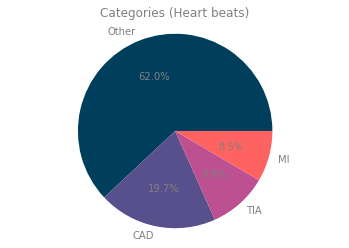

In [114]:
generate_pie_plot(full_data['Label'].value_counts())

#### Seperate into the train and the test data. Use Stratify = y to make sure the proportions are preserved

In [115]:
from sklearn.model_selection import train_test_split

# sepearte out target and input features
X = full_data.drop(['Label'], axis=1)
y_cat_codes, y_cat_string = pd.factorize(full_data['Label'])
y = pd.DataFrame(y_cat_codes, columns=['Label'], index=X.index)

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.20, random_state=10 )

Proportion of data in class Other is 3520 : 61.97 %
Proportion of data in class CAD is 1120 : 19.72 %
Proportion of data in class TIA is 560 : 9.86 %
Proportion of data in class MI is 480 : 8.45 %


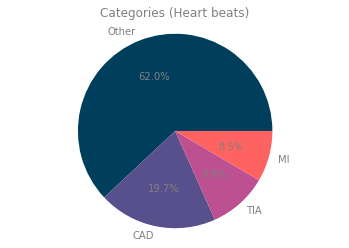

In [116]:
generate_pie_plot(y_train.value_counts(), y_cat_string)

Proportion of data in class Other is 880 : 61.97 %
Proportion of data in class CAD is 280 : 19.72 %
Proportion of data in class TIA is 140 : 9.86 %
Proportion of data in class MI is 120 : 8.45 %


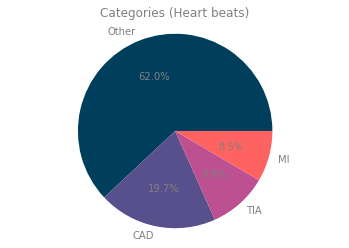

In [118]:
generate_pie_plot(y_test.value_counts(), y_cat_string)

### Artificial Neural Network model

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [176]:
y_cat_string

Index(['CAD', 'MI', 'TIA', 'Other'], dtype='object')

In [177]:
# define the neural network model
def define_model(n_input):
	# define model
	model = Sequential()
	# define first hidden layer and visible layer
	model.add(Dense(10, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
	# define output layer
	model.add(Dense(4, activation='softmax'))
	# define loss and optimizer
	model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])
	return model

trainX = X_train.values
trainy = to_categorical(y_train)
testX = X_test.values
testy = to_categorical(y_test)

# get the model
n_input = trainX.shape[1]
model = define_model(n_input)

# fit model
weights = {0:(5680/(4*1120)), 1:(5680/(4*480)), 2:(5680/(4*560)), 3:(5680/(4*3520))}
history = model.fit(trainX, trainy, class_weight=weights, epochs=100, verbose=0)

# evaluate model
yhat = model.predict(testX)
score = roc_auc_score(testy, yhat)
print('ROC AUC: %.3f' % score)

ROC AUC: 0.735


In [178]:
from sklearn.metrics import accuracy_score

def Accuracy_ConfusionMatrix(model, testX, testY, categories):
    y_predicted= model.predict(testX) 
    y_predicted = np.argmax(y_predicted, axis=1)
    testY = np.argmax(testY, axis=1)
    print(f"Accuracy of the model is {accuracy_score(testY, y_predicted)}")
    confusion_matrix = pd.crosstab(testY, y_predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        #print(f"{c} {i}")
        print(f"Class {i} : {confusion_matrix[c][c]/class_sum[c]}")

In [179]:
Accuracy_ConfusionMatrix(model, testX, testy, y_cat_string)

Accuracy of the model is 0.47464788732394364
Predicted    0   1    2    3
Actual                      
0          112  15   40  113
1           15  69    4   32
2           26   9   86   19
3          253  92  128  407
Sensitivity of model for individual classes
Class CAD : 0.4
Class MI : 0.575
Class TIA : 0.6142857142857143
Class Other : 0.4625


### Convolution Neural Network Model

In [128]:
from keras import Input, Model
from keras.layers import Convolution1D, MaxPool1D, BatchNormalization, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [188]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end1 = Dropout(0.5)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    dense_end2 = Dropout(0.5)(dense_end2)
    main_output = Dense(4, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', mode='min',patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    weights = {0:(5680/(4*1120)), 1:(5680/(4*480)), 2:(5680/(4*560)), 3:(5680/(4*3520))}
    history=model.fit(X_train, y_train,epochs=25,callbacks=callbacks, class_weight = weights, batch_size=32,validation_split=0.1)
  
    model.load_weights('best_model.h5')
    return(model,history)

In [189]:
trainX = X_train.values
testX = X_test.values
trainX =  trainX.reshape(len(trainX), trainX.shape[1],1)
testX = testX.reshape(len(testX), testX.shape[1],1)
print(trainX.shape,testX.shape)

model,history=network(trainX,trainy,testX,testy)

(5680, 1000, 1) (1420, 1000, 1)
Epoch 1/25
160/160 [==============================] - 3s 13ms/step - loss: 1.9021 - accuracy: 0.2784 - val_loss: 5.5960 - val_accuracy: 0.0739
Epoch 2/25
160/160 [==============================] - 2s 11ms/step - loss: 1.3560 - accuracy: 0.3179 - val_loss: 2.0783 - val_accuracy: 0.0810
Epoch 3/25
160/160 [==============================] - 2s 11ms/step - loss: 1.1734 - accuracy: 0.3746 - val_loss: 1.5948 - val_accuracy: 0.1901
Epoch 4/25
160/160 [==============================] - 2s 11ms/step - loss: 1.0149 - accuracy: 0.4075 - val_loss: 1.4395 - val_accuracy: 0.2852
Epoch 5/25
160/160 [==============================] - 2s 12ms/step - loss: 0.9083 - accuracy: 0.4797 - val_loss: 1.2850 - val_accuracy: 0.3926
Epoch 6/25
160/160 [==============================] - 2s 11ms/step - loss: 0.8049 - accuracy: 0.5563 - val_loss: 0.8254 - val_accuracy: 0.5616
Epoch 7/25
160/160 [==============================] - 2s 11ms/step - loss: 0.7133 - accuracy: 0.5992 - val_los

Train: 0.997, Test: 0.990


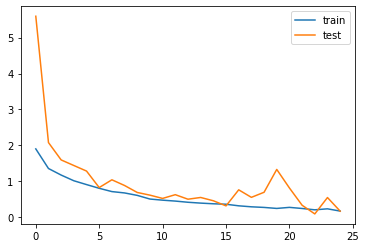

In [190]:
# evaluate the model

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

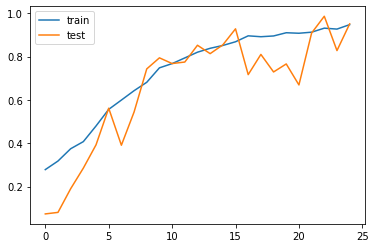

In [191]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [192]:
Accuracy_ConfusionMatrix(model, testX, testy, y_cat_string)

Accuracy of the model is 0.9901408450704225
Predicted    0    1    2    3
Actual                       
0          279    0    0    1
1            0  115    0    5
2            0    0  138    2
3            4    1    1  874
Sensitivity of model for individual classes
Class CAD : 0.9964285714285714
Class MI : 0.9583333333333334
Class TIA : 0.9857142857142858
Class Other : 0.9931818181818182


In [193]:
print(f"Baseline Accuracy on test data is {y_test.Label.value_counts()[3]/len(y_test.Label)}")

Baseline Accuracy on test data is 0.6197183098591549


## Summary

Baseline Accuracy=0.61
Accuracy with ANN=0.47
Accuracy with a 1D-CNN=0.88

Artificial neural Network is not able to capture the class seperation even after running the training at 100 epochs. The results are worse than the baseline accuracy. 
1D-CNN is able to capture the class seperation within 25 epochs. It also gives good accuracy on individual classes. The plots do not show any overfitting.

Individual class accuracy's for ANN and 1D-CNN are summarized below:
Summary:
|  Model               | ANN       | CNN         |
|----------------------|-----------|-------------|
|  Other               |   0.46    | 0.99        |
|  TIA                 |   0.61    | 0.98        |
|  MI                  |   0.57    | 0.95        |
|  CAD                 |   0.4     | 0.99        |

### Misc

In [105]:
signals, fields = wfdb.rdsamp('c:\\Workspace\\Practice\\Python\\MLSH_projects\\tmp_dl_dir\\I19', channels=[6])

In [104]:
print(fields)

{'fs': 257, 'sig_len': 462600, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V5'], 'comments': ['<age>: 18 <sex>: F', 'patient 9', 'ventricular trigeminy, PVCs']}


In [106]:
signals_clean, info = nk.ecg_process(signals.flatten() , sampling_rate=257)
